# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
print("Start import software module")
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
import sklearn
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.contrib.layers import flatten
%matplotlib inline
print("Import software module Done")
import matplotlib.image as mpimg

Start import software module
Import software module Done


In [2]:
# Load pickled data
print("Start data loading")
# TODO: fill this in based on where you saved the training and testing data
# need to revise on OSU OSC
training_file = './traffic-signs-data/train.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
test_features, test_labels = test['features'], test['labels']

del train, test
print("Data loading done")

Start data loading
Data loading done


In [3]:
### To start off let's do a basic data summary.
print("Start data summary")
# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(test_features)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = y_train[n_train -1 ] +1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print("Data summary done")

Start data summary
Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Data summary done


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

Start data exploration
                                     Random show of 100 training datasets images


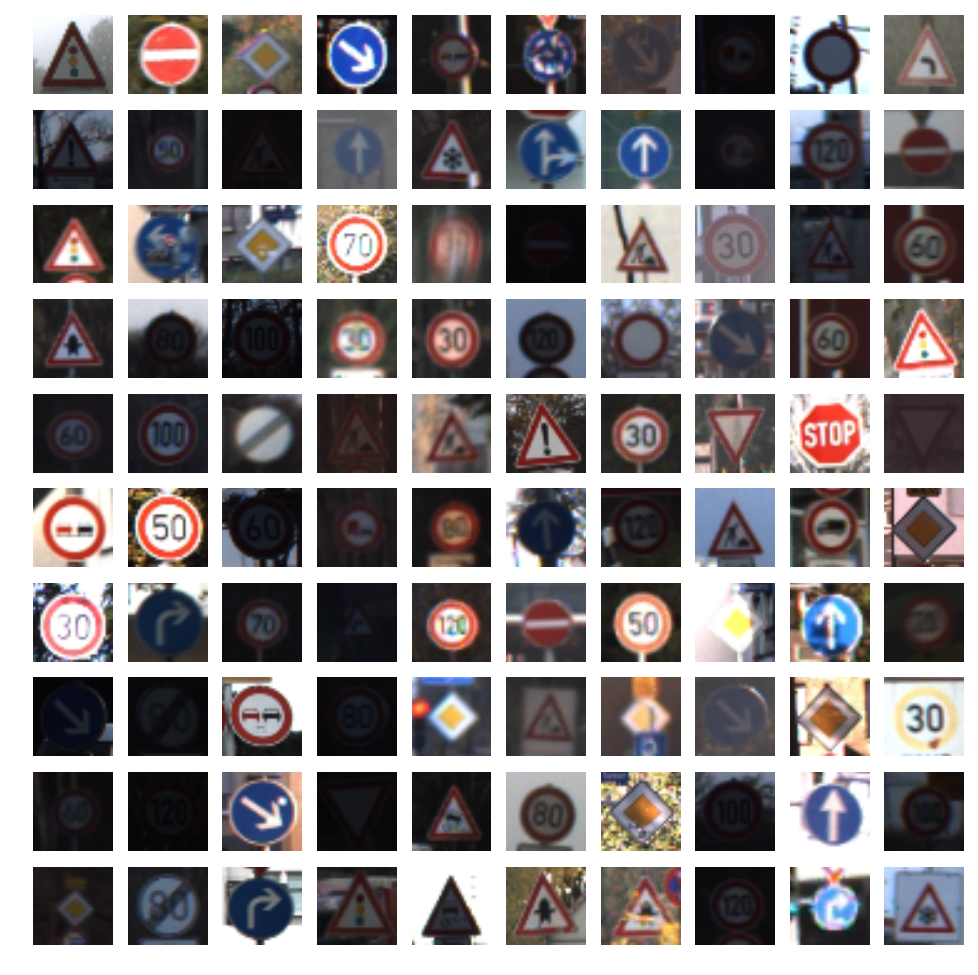

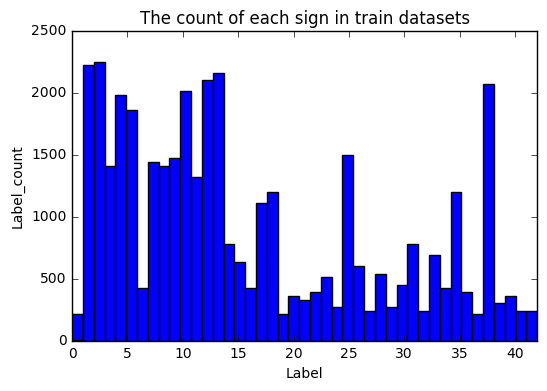

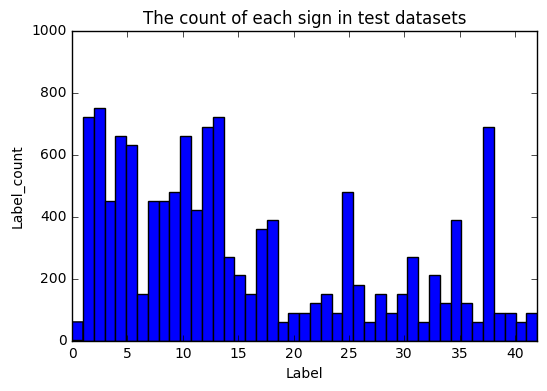

Data exploration done


In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
print('Start data exploration')
print('                                     Random show of 100 training datasets images')
#randomly pick and sign and plot
gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 
plt.figure(figsize=(12,12))
for i in range(100):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = X_train[random.randint(0, len(X_train))]

    plt.subplot(10,10,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

#plotting the count of each sign in train datasets and test datasets
plt.figure(2)
plt.xlabel('Label')
plt.ylabel('Label_count')
plt.axis([0, 42, 0, 2500])
plt.title('The count of each sign in train datasets')
plt.hist(y_train, n_classes)

plt.figure(3)
plt.xlabel('Label')
plt.ylabel('Label_count')
plt.axis([0, 42, 0, 1000])
plt.title('The count of each sign in test datasets')
plt.hist(test_labels, n_classes)
plt.show()

print('Data exploration done')    

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Start preprocess


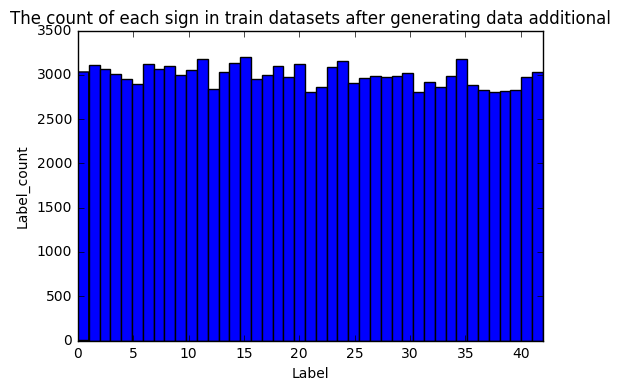

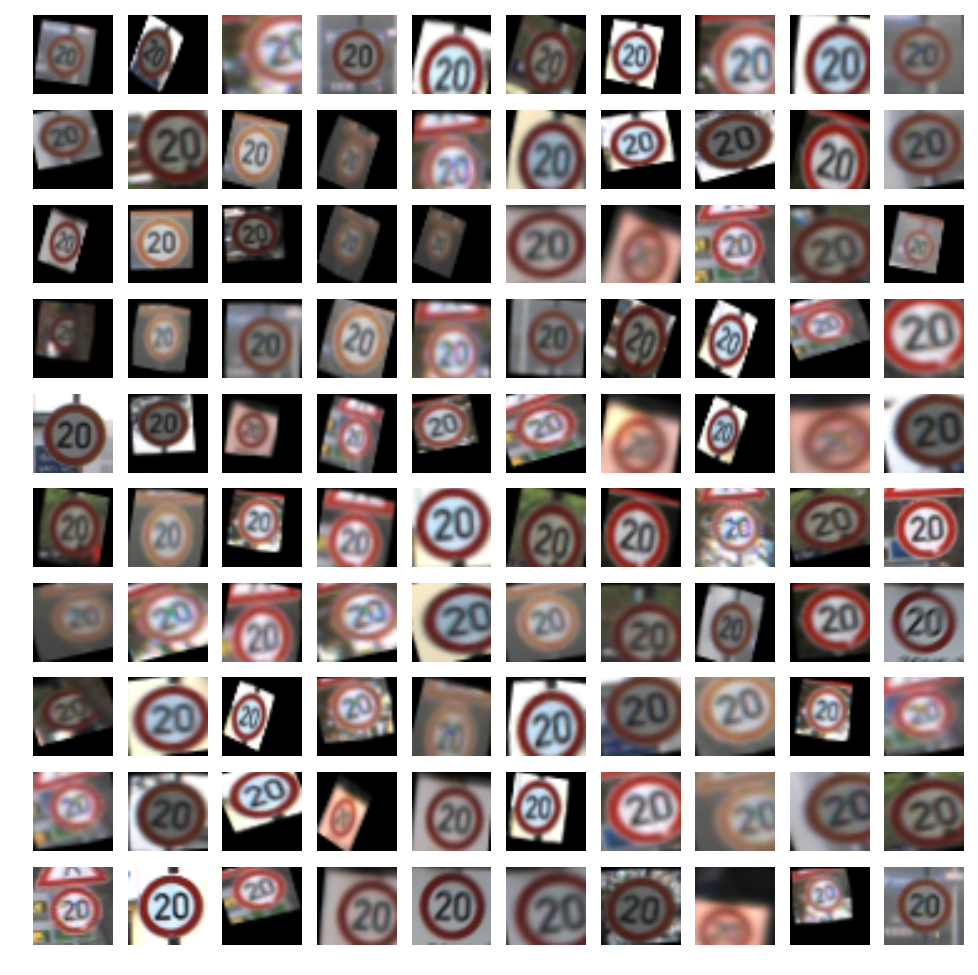

preprocess done


In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.

print("Start preprocess")
#define a min-max scaling function used to normalize the image data
def normalize_inputimage(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )

def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function was borrowed from here original by Vivek Yadav:
    https://carnd-forums.udacity.com/questions/10322627/project-2-unbalanced-data-generating-additional-data-by-jittering-the-original-image
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

#generate new training data to make the data balance
inputs_per_class = np.bincount(y_train)
# each class will have 2800-3200 training examples 
for i in range(len(inputs_per_class)):
    add_number = 3000 + random.randint(-200, 200) - inputs_per_class[i]
    
    new_features = []
    new_labels = []
    mask = np.where(y_train == i)
    features = X_train[mask]
    for j in range(add_number):
        index = random.randint(0, inputs_per_class[i] - 1)
        new_features.append(transform_image(features[index],20, 10, 5))
        new_labels.append(i)
    X_train = np.append(X_train, new_features, axis=0)
    y_train = np.append(y_train, new_labels, axis=0)
del new_features, new_labels

#plot the count of each sign in train datasets after generating data additiona    
plt.figure(4)
plt.xlabel('Label')
plt.ylabel('Label_count')
plt.axis([0, 42, 0, 3500])
plt.title('The count of each sign in train datasets after generating data additional')
plt.hist(y_train, n_classes)

mask = np.where(y_train == 0)
features = X_train[mask]
gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 
plt.figure(figsize=(12,12))
for i in range(100):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = features[random.randint(0, 2800)]

    plt.subplot(10,10,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

#Normorlization, scale the image data from [0 255] to [0.1 0.9]
X_train = normalize_inputimage(X_train)
test_features = normalize_inputimage(test_features)

# randomly split the original training data into training and validation
train_features, validation_features, train_labels, validation_labels = train_test_split(
   X_train,
   y_train,
   test_size=0.2,
   random_state=36452
)

# One-hot encoded training and validation labels
train_labels = tf.one_hot(train_labels, n_classes).eval(session=tf.Session())
validation_labels = tf.one_hot(validation_labels, n_classes).eval(session=tf.Session())

print('preprocess done')


### Question 1 

_Describe the techniques used to preprocess the data._


**Answer:**
I  use two  preprocessing step in my implementation:

1/  From the data visulazation part, we can see that the trainning data is not balanced, so  I use the  AffineTransform in Opencv to generate additional dataset to make the training datasets balance.

2/ Normalize the image  pixel value from [0,255] to [0.1,0.9].

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_


**Answer:**
I split the original tainning dataset in to traing(80%) and validation(20%) part using the  train_test_split function of sklearn. The original test data will keep as the test datasets. I will test my  network using validation data  for each epoch, and only test on testing dataset  when I am satisfied with my model and network.

I generate additional dataset to make the training datasets balance, as I exaplianed in question 1. In this way, the number of  training sets for each label is approxmately the same .

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# Parameters
learning_rate = 0.01
batch_size = 128
training_epochs = 200
#number of classes in the German traffic sign datasets
n_classes = 43  

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My architecture is exactly the LeNet, except that the filters on the first layer has 3 channels, and  the last output  of the last fully-connected layer is 43 instead of 10.

Do you  have any suggestion on how to modify LeNet to apply on our task?


In [7]:
### Train your model here.
### Feel free to use as many code cells as needed.

#Prepare to train the model
# tf Graph input
x = tf.placeholder("float32", [None, 32, 32, 3])
y = tf.placeholder("float32", [None, n_classes])

logits = LeNet(x)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
#optimizer = tf.train.AdamOptimizer().minimize(cost)


# Initializing the variables
init = tf.global_variables_initializer()
saver = tf.train.Saver() 
number_train = len(train_labels)

In [ ]:
# Launch the graph and train the model
with tf.Session() as sess:
    sess.run(init)
    # Training cycle
    for epoch in range(training_epochs):
        total_batch = int(number_train/batch_size)
        # Loop over all batches
        for i in range(total_batch):        
            #randomly seletcly batch_zise train data
            indices = np.random.random_integers(0, number_train-1, batch_size)
            batch_x, batch_y = train_features[indices], train_labels[indices]
            
            # Run optimization op (backprop) and cost op (to get loss value)
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
            
        # Display logs per epoch step
        c = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
    print("Optimization Finished!")
    save_path = saver.save(sess, "./model/model.ckpt")
    print("Model saved in file: %s" % save_path)

    # Test model, compare if predicted class equals the true class of each image
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float32"))
    print(
        "Accuracy:",
        accuracy.eval({x: validation_features, y: validation_labels}))

In [8]:
# launch the model being train on a cluster, and test if we save it correctly.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(init)
#saver = tf.train.Saver()
# Restore variables from disk.
saver.restore(sess, "./model/model.ckpt")
print("Model restored.")
# Calculate the accuracy on validation data
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float32"))
print(
    "Validation Accuracy:",
    sess.run(accuracy, feed_dict={x: validation_features, y: validation_labels}))

Model restored.
Validation Accuracy: 0.914205


In [13]:
# test on testing datasets after we are happy with the validation accuracy
# Calculate the accuracy on validation data
test_labels = tf.one_hot(test_labels, n_classes).eval(session=tf.Session())
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float32"))
print(
    "Test Accuracy:",
    sess.run(accuracy, feed_dict={x: test_features, y: test_labels}))

Test Accuracy: 0.845368


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I trained my architectures GradientDescent Optimizer with a learning rate of 0.001, a batch size of 128 and 100 training epochs.
The test time on Tesla K40 GPU is  18 minutes.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**
This  problem is similar to the  handwriting digits recognition problem , and LeNet is a good architectures to tackle that problem. So I start from LeNet and found that LeNet can  also  get pretty good results on this problem.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

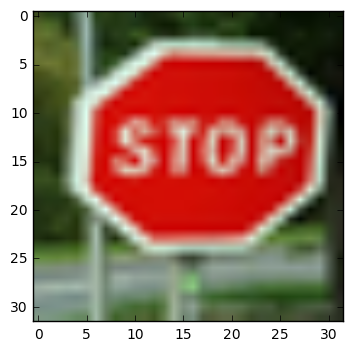

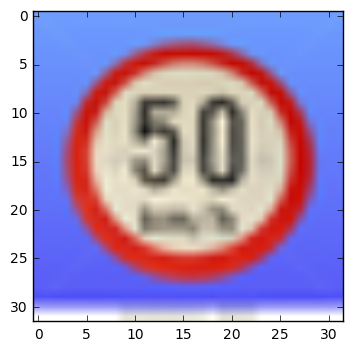

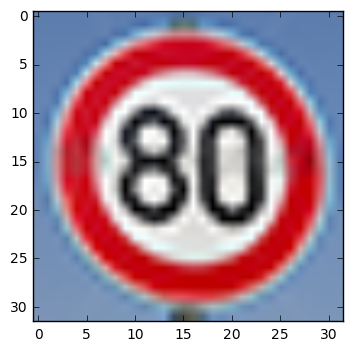

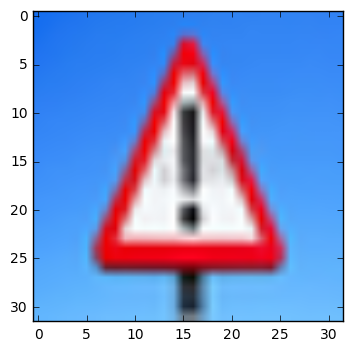

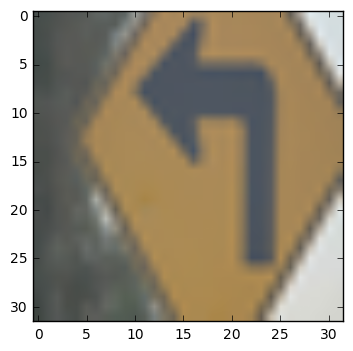

In [19]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
imgs = ['stopsign.png', '50km_speed_limit.png', '80km_speed_limit.png', 'general_caution.png','leftturn.png']

mytest_img = []

for imgname in imgs:
    image = mpimg.imread('test_images/' + imgname)
    mytest_img.append(image)
    plt.imshow(image)
    plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

There is lots of examples for my chosen first 3 images, so I got very good accuracy on them. For last two images, they are not contained in our training datasets 43 classes, but it is interesting to see  how they are classified.

I searched the internet and chose the above 5 images, and then resize them to [32 32 3] before put them in our model. In my case, the quality of the images  is equal to our training datasets.


In [20]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
prediction = tf.nn.softmax(logits)
my_prediction = sess.run(prediction, feed_dict={x: mytest_img})

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_


**Answer:**
 Yes if  the captured pictures belongs to the  43 classes.

In [21]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
print(my_prediction)

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
    0.00000000e+00   2.17883481e-36   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.50705204e-09   1.17959633e-08   1.00000000e+00   5.45326522e-19
    9.00752951e-19   4.45460970e-13   0.00000000e+00   4.89006448e-12
    2.29098132e-21   2.97391371e-36   4.32810864e-36   0.00000000e+00
    0.00000000e+00   0.00000000e+00 

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**


In [22]:
#open and read signnames.csv
import csv
k = 5
with open('signnames.csv', mode='r') as infile:
    reader = csv.reader(infile)
    signnames = dict((rows[0],rows[1]) for rows in reader)
values, indices = sess.run(tf.nn.top_k(prediction, k), feed_dict={x: mytest_img})
for i in range(len(values)):
    print()
    print("Top", k, "prediction for image",imgs[i])
    for j in range(k):
        print("{}={:.1f}%".format(signnames[str(indices[i,j])], values[i,j] * 100,))  
          


Top 5 prediction for image stopsign.png
Stop=100.0%
No entry=0.0%
Speed limit (20km/h)=0.0%
Speed limit (30km/h)=0.0%
Speed limit (50km/h)=0.0%

Top 5 prediction for image 50km_speed_limit.png
Speed limit (50km/h)=100.0%
Speed limit (30km/h)=0.0%
Speed limit (20km/h)=0.0%
Speed limit (100km/h)=0.0%
Speed limit (80km/h)=0.0%

Top 5 prediction for image 80km_speed_limit.png
Speed limit (80km/h)=100.0%
Speed limit (50km/h)=0.0%
Speed limit (30km/h)=0.0%
Speed limit (60km/h)=0.0%
Speed limit (20km/h)=0.0%

Top 5 prediction for image general_caution.png
Traffic signals=99.9%
Road narrows on the right=0.1%
Pedestrians=0.0%
General caution=0.0%
Road work=0.0%

Top 5 prediction for image leftturn.png
Speed limit (20km/h)=100.0%
Speed limit (120km/h)=0.0%
Speed limit (60km/h)=0.0%
Speed limit (30km/h)=0.0%
Speed limit (100km/h)=0.0%


### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.